In [17]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

# Downloads NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Carregando o dataset (Section 1: Dataset)
df = pd.read_excel('BBC.xlsx')  # Verifique o formato e o nome correto do arquivo

ModuleNotFoundError: No module named 'imblearn'

In [12]:
# Pré-processamento de texto (Section 2: Classification pipeline)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
blacklist = ['said']

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words and word not in blacklist]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Vetorização TF-IDF para melhorar a qualidade da representação dos textos
vectorizer = TfidfVectorizer(max_features=5000)  # Limitando a 5000 palavras para otimizar performance
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Dividindo os dados para treino e teste 
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['category'], test_size=0.2, stratify=df['category'], random_state=42)

# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB()
}

# Função para treinar e avaliar o modelo com matrizes de confusão e acurácia balanceada
def train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, num_iterations=10):
    train_accuracies, test_accuracies = [], []
    balanced_accuracies = []
    conf_matrices = np.zeros((len(df['category'].unique()), len(df['category'].unique())))

    for _ in range(num_iterations):
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X_train_tfidf, y_train, test_size=0.2, stratify=y_train
        )
        
        model.fit(X_train_split, y_train_split)
        
        y_train_pred = model.predict(X_train_split)
        y_test_pred = model.predict(X_test_split)
        
        train_accuracies.append(accuracy_score(y_train_split, y_train_pred))
        test_accuracies.append(accuracy_score(y_test_split, y_test_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test_split, y_test_pred))
        
        conf_matrices += confusion_matrix(y_test_split, y_test_pred)

    mean_train_accuracy = np.mean(train_accuracies)
    mean_test_accuracy = np.mean(test_accuracies)
    mean_balanced_accuracy = np.mean(balanced_accuracies)

    print(f'Mean Training Accuracy: {mean_train_accuracy:.4f}')
    print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')
    print(f'Mean Balanced Accuracy: {mean_balanced_accuracy:.4f}')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrices / num_iterations, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Função para obter as palavras mais importantes para cada categoria
def get_top_words_per_category(model, vectorizer, X_train_tfidf, y_train, category_label, top_n=5):
    category_index = list(df['category'].unique()).index(category_label)
    
    # Verifica se o modelo é linear e pode gerar coeficientes
    if hasattr(model, 'coef_'):
        category_coef = model.coef_[category_index]
        top_indices = np.argsort(category_coef)[-top_n:]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        print(f"\nTop {top_n} words for category '{category_label}':")
        print(", ".join(top_words))



Logistic Regression Model:
Mean Training Accuracy: 0.9960
Mean Test Accuracy: 0.9764
Mean Balanced Accuracy: 0.9760


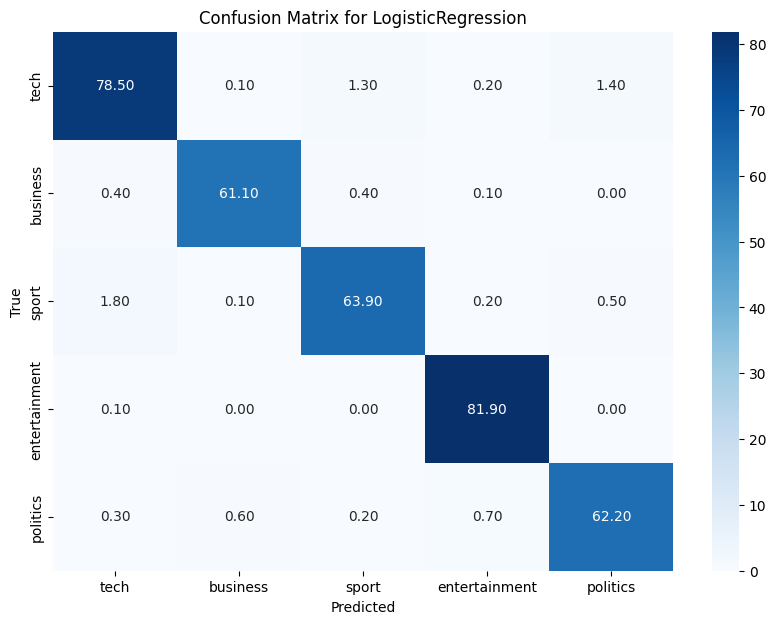


Top 5 words for category 'tech':
market, firm, share, company, bank

Top 5 words for category 'business':
award, star, music, show, film

Top 5 words for category 'sport':
minister, government, party, labour, mr

Top 5 words for category 'entertainment':
cup, player, champion, club, match

Top 5 words for category 'politics':
user, computer, technology, software, game

Naive Bayes Model:
Mean Training Accuracy: 0.9872
Mean Test Accuracy: 0.9683
Mean Balanced Accuracy: 0.9674


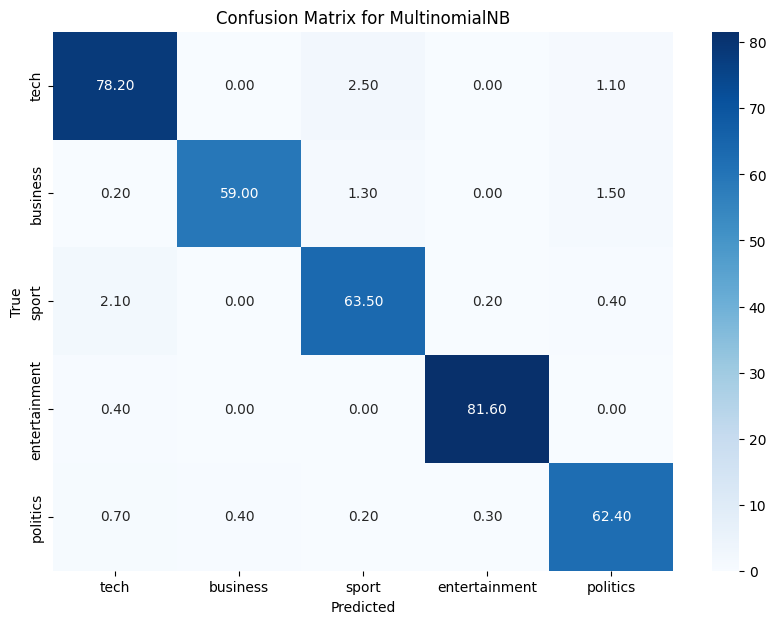

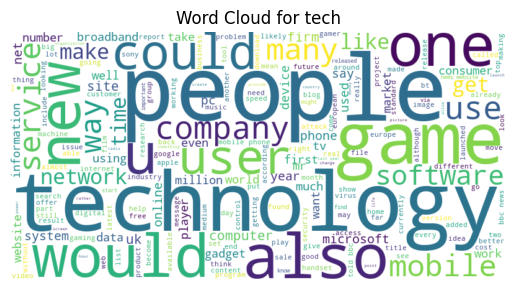

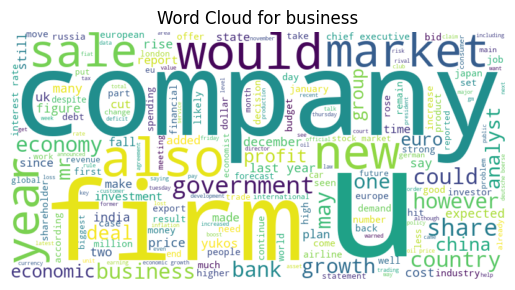

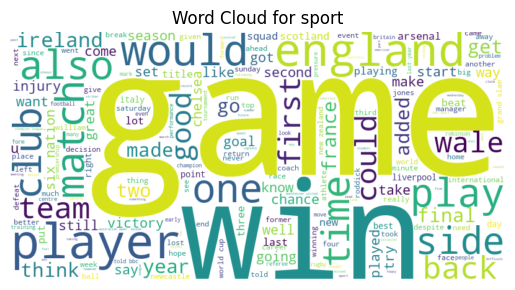

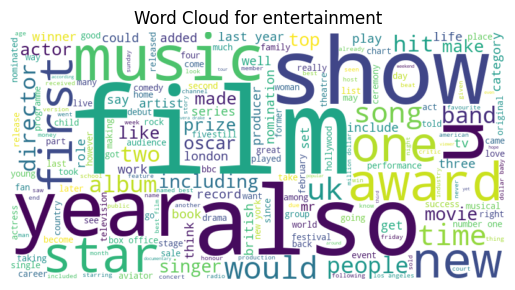

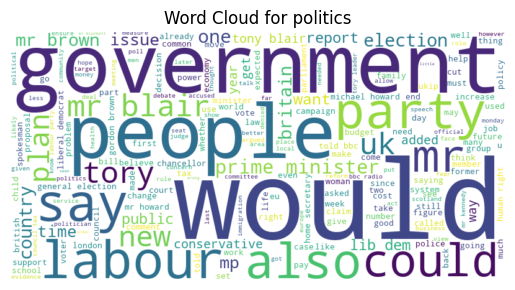

In [13]:
# Avaliação com os modelos definidos (Section 3: Evaluation)
for name, model in models.items():
    print(f"\n{name} Model:")
    train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, num_iterations=10)

    # Mostrando as palavras mais importantes para cada categoria
    for category in df['category'].unique():
        get_top_words_per_category(model, vectorizer, X_train_tfidf, y_train, category)

# Análise de Nuvem de Palavras para cada categoria
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=blacklist).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

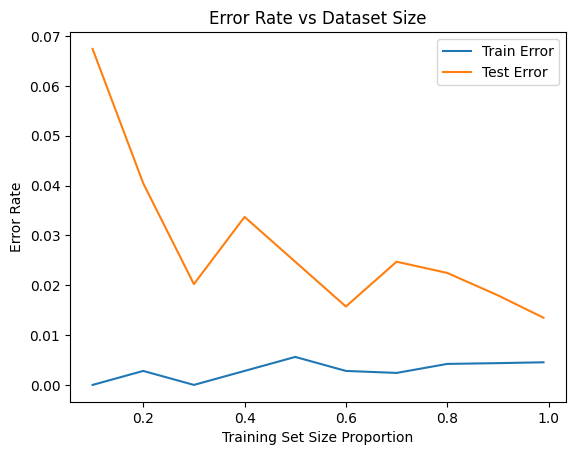

In [14]:
# Avaliação de desempenho com downsampling do dataset (Section 4: Dataset Size)
sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
train_errors, test_errors = [], []

for size in sample_sizes:
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train_tfidf, y_train, train_size=size, stratify=y_train)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_sample, y_train_sample)
    train_errors.append(1 - model.score(X_train_sample, y_train_sample))
    test_errors.append(1 - model.score(X_test_tfidf, y_test))

plt.figure()
plt.plot(sample_sizes, train_errors, label='Train Error')
plt.plot(sample_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size Proportion')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Dataset Size')
plt.legend()
plt.show()

In [15]:
# Análise de Tópicos com LDA (Section 5: Topic Analysis)
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Divisão do dataset ANTES de rodar o LDA, para garantir a consistência
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_tfidf, y_train, test_size=0.4, stratify=y_train)

# Aplicando LDA APÓS a divisão dos dados
X_train_topics = lda.fit_transform(X_train_split)
X_test_topics = lda.transform(X_test_split)

# Análise de Tópicos com LDA (Section 5: Topic Analysis)
lda = LatentDirichletAllocation(n_components=5, random_state=42)

# Divisão do dataset ANTES de rodar o LDA, para garantir a consistência
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_tfidf, y_train, test_size=0.4, stratify=y_train)

# Aplicando LDA APÓS a divisão dos dados
X_train_topics = lda.fit_transform(X_train_split)
X_test_topics = lda.transform(X_test_split)

# Função para imprimir as palavras mais relevantes de cada tópico
def print_words_in_topics(model, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-10:]:
            print(words[i])
        print()
    print()

# Visualizando os tópicos gerados pelo LDA
print_words_in_topics(lda, vectorizer)

# Threshold for assigning topics (documents that don't meet the threshold will be ambiguous)
def assign_topic_with_threshold(topic_distributions, threshold=0.2):
    topic_assignment = []
    for distribution in topic_distributions:
        if np.max(distribution) >= threshold:
            topic_assignment.append(np.argmax(distribution))
        else:
            topic_assignment.append(-1)  # Label as 'ambiguous' if below threshold
    return np.array(topic_assignment)

# Função de classificação de duas camadas SEM validação cruzada
def two_layer_classifier(X_train_tfidf, X_train_topics, X_test_tfidf, X_test_topics, y_train, y_test):
    
    # Topic assignment with threshold
    train_topic_assignment = assign_topic_with_threshold(X_train_topics, threshold=0.2)
    test_topic_assignment = assign_topic_with_threshold(X_test_topics, threshold=0.2)

    # Filter out ambiguous samples (-1)
    train_valid_idx = train_topic_assignment != -1
    test_valid_idx = test_topic_assignment != -1

    X_train_valid = X_train_tfidf[train_valid_idx]
    y_train_valid = y_train[train_valid_idx]

    X_test_valid = X_test_tfidf[test_valid_idx]
    y_test_valid = y_test[test_valid_idx]

    ros = RandomOverSampler(random_state=42)
    X_train_topics_res, y_train_res = ros.fit_resample(X_train_valid, y_train_valid)

    # Classificação de tópicos com peso balanceado (camada 1)
    lda_classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
    lda_classifier.fit(X_train_topics_res, y_train_res)

    # Avaliação na camada de tópicos
    topic_predictions = lda_classifier.predict(X_test_valid)
    topic_accuracy = accuracy_score(y_test_valid, topic_predictions)
    print(f"Accuracy for topic classification: {topic_accuracy}")

    category_accuracies = {}

    # Classificação dentro de cada tópico (camada 2)
    for topic in np.unique(X_train_topics.argmax(axis=1)):
        idx_train = X_train_topics.argmax(axis=1) == topic
        idx_test = X_test_topics.argmax(axis=1) == topic

        train_samples = np.sum(idx_train)
        test_samples = np.sum(idx_test)
        print(f"Topic {topic} has {train_samples} train samples and {test_samples} test samples.")
        
        if train_samples > 0 and test_samples > 0:
            X_topic_train = X_train_valid[idx_train]
            y_topic_train = y_train[idx_train]

            X_topic_test = X_test_valid[idx_test]
            y_topic_test = y_test[idx_test]

            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            clf.fit(X_topic_train, y_topic_train)

            # Avaliação dentro do tópico
            y_pred_topic = clf.predict(X_topic_test)
            category_accuracy = accuracy_score(y_topic_test, y_pred_topic)
            
            # Guardando as acurácias por tópico
            if topic not in category_accuracies:
                category_accuracies[topic] = []
            category_accuracies[topic].append(category_accuracy)

            print(f"Accuracy for category classification in topic {topic}: {category_accuracy}")
        else:
            print(f"No data for topic {topic}")

    # Média de acurácia para a classificação de tópicos
    avg_topic_accuracy = np.mean(topic_accuracies)
    print(f"\nAverage topic classification accuracy: {avg_topic_accuracy}")
    
    # Média de acurácia para cada tópico
    for topic in category_accuracies:
        avg_category_accuracy = np.mean(category_accuracies[topic])
        print(f"Average category classification accuracy in topic {topic}: {avg_category_accuracy}")

# Rodando o classificador de duas camadas sem validação cruzada
two_layer_classifier(X_train_split, X_train_topics, X_test_split, X_test_topics, y_train_split, y_test_split)


Topic 0
uk
one
government
also
game
new
people
would
year
mr

Topic 1
england
williams
match
ireland
champion
oscar
win
best
film
award

Topic 2
delta
spammer
laser
screensaver
thanou
kenteris
greek
handset
iaaf
spam

Topic 3
fockers
skype
sullivan
infected
boerse
worldcom
blog
lse
ebbers
virus

Topic 4
figure
manufacturing
export
economist
rise
quarter
price
economy
growth
rate


Accuracy for topic classification: 0.4592696629213483
Topic 0 has 988 train samples and 674 test samples.
Accuracy for category classification in topic 0: 0.9629080118694362
Topic 1 has 78 train samples and 38 test samples.
Accuracy for category classification in topic 1: 1.0
Topic 4 has 2 train samples and 0 test samples.
No data for topic 4

Average topic classification accuracy: 0.4592696629213483
Average category classification accuracy in topic 0: 0.9629080118694362
Average category classification accuracy in topic 1: 1.0
